## Seacher:
Theis file is to search the image in the 25000 images database, using color histogram

Import

In [1]:
import numpy as np
import csv

class Searcher:
    def __init__(self, indexPath):
        # store our index path
        self.indexPath = indexPath
 
    def search(self, queryFeatures, limit = 10):
        # initialize our dictionary of results
        results = {}
        with open(self.indexPath) as f:
            # initialize the CSV reader
            reader = csv.reader(f)
            
            # loop over the rows in the index
            for row in reader:
                # parse out the image ID and features, then compute the
                # chi-squared distance between the features in our index
                # and our query features
                features = [float(x) for x in row[1:]]
                d = self.chi2_distance(features, queryFeatures)
                # now that we have the distance between the two feature
                # vectors, we can udpate the results dictionary -- the
                # key is the current image ID in the index and the
                # value is the distance we just computed, representing
                # how 'similar' the image in the index is to our query
                results[row[0]] = d
            # close the reader
            f.close()
        # sort our results, so that the smaller distances (i.e. the
        # more relevant images are at the front of the list)
        results = sorted([(v, k) for (k, v) in results.items()])
        # return our (limited) results
        return results[:limit]
    
    def chi2_distance(self, histA, histB, eps = 1e-10):
        # compute the chi-squared distance
        d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for (a, b) in zip(histA, histB)])
 
        # return the chi-squared distance
        return d
    

## Color Descriptor

In [2]:
import numpy as np
import cv2
import imutils

class ColorDescriptor:
    def __init__(self, bins):
        # store the number of bins for the 3D histogram
        self.bins = bins
 
    def describe(self, image):
        # convert the image to the HSV color space and initialize
        # the features used to quantify the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []
 
        # grab the dimensions and compute the center of the image
        (h, w) = image.shape[:2]
        (cX, cY) = (int(w * 0.5), int(h * 0.5))
        # divide the image into four rectangles/segments (top-left,
        # top-right, bottom-right, bottom-left)
        segments = [(0, cX, 0, cY), 
                    (cX, w, 0, cY), 
                    (cX, w, cY, h),
                    (0, cX, cY, h)]
        # construct an elliptical mask representing the center of the
        # image
        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
        
        # loop over the segments
        for (startX, endX, startY, endY) in segments:
            # construct a mask for each corner of the image, subtracting
            # the elliptical center from it
            cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(cornerMask, ellipMask)
 
            # extract a color histogram from the image, then update the
            # feature vector
            hist = self.histogram(image, cornerMask)
            features.extend(hist)
 
        # extract a color histogram from the elliptical region and
        # update the feature vector
        hist = self.histogram(image, ellipMask)
        features.extend(hist)
        
        return features
        
        
    def histogram(self, image, mask):
        # extract a 3D color histogram from the masked region of the
        # image, using the supplied number of bins per channel
        hist = cv2.calcHist([image], 
                            [0, 1, 2], 
                            mask, 
                            self.bins,
                            [0, 180, 0, 256, 0, 256])
        
        # normalize the histogram
        hist = cv2.normalize(hist, hist).flatten()
        # return the histogram
        return hist

## Performing a Search

In [3]:
cd = ColorDescriptor((8, 12, 3))
index_dir = 'color_based_feature/index.csv'
query_image_dir = 'query_image/query_1.jpg'

# query image put here

In [4]:
query = cv2.imread(query_image_dir)

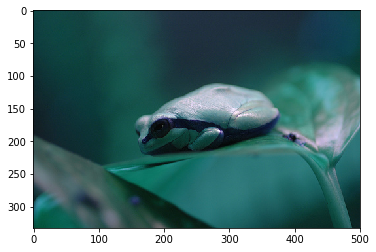

In [16]:
import matplotlib.pyplot as plt
features = cd.describe(query)
 
# perform the search
searcher = Searcher(index_dir)
results = searcher.search(features)

# display the query
plt.imshow(query)

# cv2.imshow("Query", query)
# loop over the results
for (score, resultID) in results:
    # load the result image and display it
    result = cv2.imread(resultID)
    plt.imshow(result)
plt.show()
    # cv2.imshow("Result", result)
    # cv2.waitKey(0)

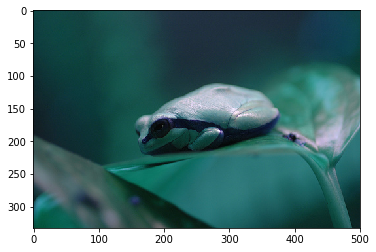

In [17]:
plt.imshow(result)
plt.show()